In [106]:
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import re
import fnmatch
import matplotlib.pyplot as plt
from functools import reduce
from bs4 import BeautifulSoup
import requests
import osmnx as ox
from API_KEY import get_OneMap_token
import networkx as nx

import helper_functions.utils as utils

# Import road network

In [2]:
save_dir = os.path.join(os.getcwd(),"Data","Road_Networks")
# import bus network
filename = "SG_bus_network.graphml"
G_bus = ox.load_graphml(os.path.join(save_dir,filename))

# import car network
filename = "SG_car_network.graphml"
G_car = ox.load_graphml(os.path.join(save_dir,filename))

# import walking network
filename = "SG_walk_network.graphml"
G_walk = ox.load_graphml(os.path.join(save_dir, filename))

# Import planning area

<class 'geopandas.geodataframe.GeoDataFrame'>


,Name,Description,geometry,PLN_AREA_N,PLN_AREA_C,CA_IND,REGION_N,REGION_C,INC_CRC,FMEL_UPD_D
0,kml_1,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.93208 1.30555 0, 103.93208 1.3...",BEDOK,BD,N,EAST REGION,ER,5F00E6FF084F3364,20191223152014
1,kml_2,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.72042 1.32824 0, 103.72003 1.3...",BOON LAY,BL,N,WEST REGION,WR,C96AED188C00B2FC,20191223152014
2,kml_3,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.76408 1.37001 0, 103.76444 1.3...",BUKIT BATOK,BK,N,WEST REGION,WR,3BEC4C829160F28A,20191223152014
3,kml_4,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.82361 1.26018 0, 103.82362 1.2...",BUKIT MERAH,BM,N,CENTRAL REGION,CR,4850795BB0B6A4F7,20191223152014
4,kml_5,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.77445 1.39029 0, 103.77499 1.3...",BUKIT PANJANG,BP,N,WEST REGION,WR,656F87D23D6DAB02,20191223152014


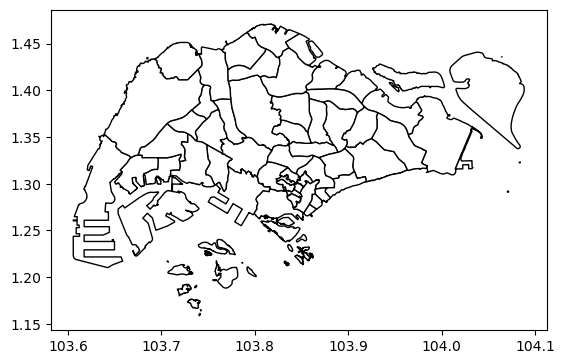

In [3]:
planningArea_noSea = gpd.read_file(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_Masterplan\MasterPlan2019PlanningAreaBoundaryNoSea.geojson")

def extract_html_tags(row):
    html_content = row["Description"]
    soup = BeautifulSoup(html_content,"html.parser")
    ths = soup.find_all('th')
    tds = soup.find_all('td')
    column_names = []
    column_values = []
    for th in ths:
        column_names.append(th.get_text())
    for td in tds:
        column_values.append(td.get_text())
    column_names = column_names[1:] # remove the first "Attribute"
    return pd.Series({k:v for k,v in zip(column_names,column_values)})
# column_names, _ = extract_html_tags(planningArea_noSea.iloc[0,1])
planningArea_shp = planningArea_noSea.join(planningArea_noSea.apply(extract_html_tags,axis=1))
print(type(planningArea_shp))
planningArea_shp.plot(fc='white',ec='k')
planningArea_shp.head()

### Import GTFS stops

Length of GTFS:  5251


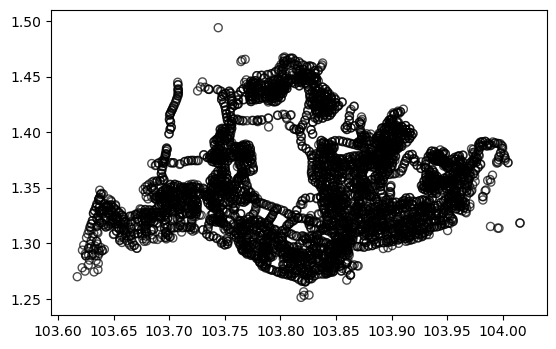

In [32]:
GTFS_stops = pd.read_csv(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_LTA\gtfs-feed-lta\stops.txt")
GTFS_stops['nodesID_GTFS'] = ox.nearest_nodes(G_car,X=GTFS_stops['stop_lon'],Y=GTFS_stops['stop_lat'])
GTFS_stops = gpd.GeoDataFrame(GTFS_stops, geometry=gpd.points_from_xy(GTFS_stops['stop_lon'], GTFS_stops['stop_lat']), crs=planningArea_shp.crs)
print("Length of GTFS: ", len(GTFS_stops))
GTFS_stops.head()
# add a buffer of 400m
def add_buffer(gdf,buffer_dist=400,plot=True):
    """ 
    returns a GeoSeries (polygon geometry) of the buffered area
    Args:
        gdf (Geo.DataFrame)
        buffer_dist (float): distance in meters
        plot (bool): If True, plot geoseries of the buffered area
    """
    gdf_buffer = gdf.to_crs({'proj':'cea'})
    gdf_buffer = gdf_buffer['geometry'].buffer(400)
    gdf_buffer = gdf_buffer.to_crs(planningArea_shp.crs)
    if plot:
        gdf_buffer.plot(fc="None", ec="k",alpha=0.7)
    return gdf_buffer

GTFS_stops_400m_buffer = add_buffer(GTFS_stops, buffer_dist=400, plot=True)


#### Filter bus stops from GTFS

Length of bus stops:  5061


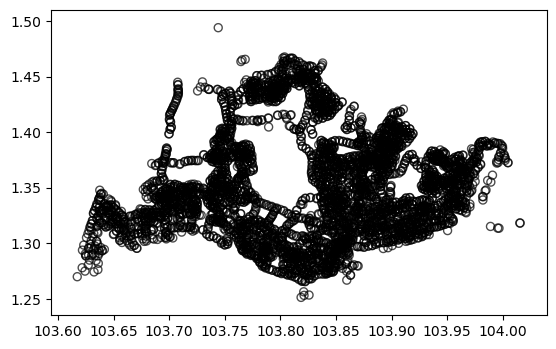

In [48]:
busStops = GTFS_stops[GTFS_stops['stop_code'].str.isdigit()] # MRT stops is alphanumeric, but busstop stop codes are only numeric
print("Length of bus stops: ", len(busStops))
# add a buffer of 400m
busStops_400m_buffer = busStops.copy()
busStops_400m_buffer['geometry'] = add_buffer(busStops, buffer_dist=400, plot=True)

### Import train exit stations

[Diao et al, 2017](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2899470) "We find significant capitalization of the new CL into housing prices, especially households living within a 400-meter radius (the treatment zone) from the closest MRT stations on the CL. The treatment effects that are measured by the marginal willingness to pay for houses located within the treatment zone is 13.2% relative to houses located outside the treatment zone. "

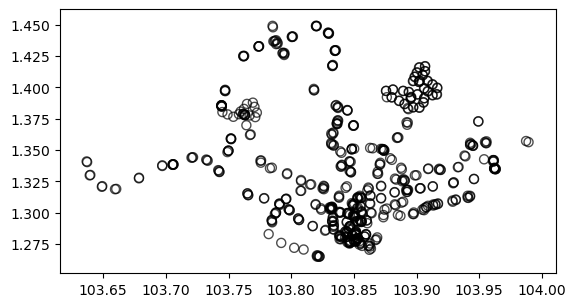

In [49]:
trainExits = gpd.read_file(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_LTA\TrainStationExit\Train_Station_Exit_Layer.shp")
trainExits = trainExits.to_crs(planningArea_shp.crs)
trainExits['exit_lat'] = trainExits['geometry'].y
trainExits['exit_lon'] = trainExits['geometry'].x
trainExits['nodesID_trainExit'] = ox.nearest_nodes(G_car,X=trainExits['exit_lon'],Y=trainExits['exit_lat'])
trainExits.head()
# TODO: May need to remove all the TEL mrt stations since they were not built yet before 2022
# add a buffer of 400m
trainExits_400m_buffer = trainExits.copy()
trainExits_400m_buffer['geometry'] = add_buffer(trainExits, buffer_dist=400, plot=True)

### Import workplace cluster

   PLN_AREA_N                  LU_DESC PLN_AREA_C     REGION_N REGION_C  \
44     TENGAH  EDUCATIONAL INSTITUTION         TH  WEST REGION       WR   

    latitude   longitude      node_ID                   geometry  
44  1.357293  103.733877  11717444138  POINT (103.73051 1.36398)  
Length of df:  50
Number of unique regions:  50


,PLN_AREA_N,LU_DESC,PLN_AREA_C,REGION_N,REGION_C,latitude,longitude,node_ID,geometry
2,BISHAN,COMMERCIAL,BS,CENTRAL REGION,CR,1.353185,103.838386,310582393,POINT (103.83839 1.35319)
5,BUKIT MERAH,COMMERCIAL,BM,CENTRAL REGION,CR,1.282412,103.823409,409638755,POINT (103.82341 1.28241)
7,BUKIT TIMAH,RESIDENTIAL WITH COMMERCIAL AT 1ST STOREY,BT,CENTRAL REGION,CR,1.333500,103.786494,6144151504,POINT (103.78649 1.3335)
12,DOWNTOWN CORE,UTILITY,DT,CENTRAL REGION,CR,1.286690,103.852118,7202314880,POINT (103.85212 1.28669)
13,GEYLANG,UTILITY,GL,CENTRAL REGION,CR,1.316940,103.885235,8655329609,POINT (103.88524 1.31694)


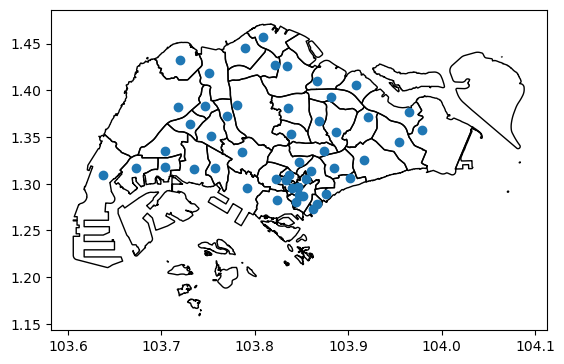

In [6]:
workplace_cluster = gpd.read_file(r"Data\workplace_cluster_planningArea.shp")
# replace latitude and longitude coordinates for the row that corresponds to the PLN_AREA_N "TENGAH"
workplace_cluster.loc[workplace_cluster['PLN_AREA_N'] == 'TENGAH', ['latitude','longitude']] = [1.357293, 103.733877]
workplace_cluster.loc[workplace_cluster['PLN_AREA_N'] == 'TENGAH', 'node_ID'] = ox.distance.nearest_nodes(G_car,X = 103.733877, Y = 1.357293)
print(workplace_cluster[workplace_cluster['PLN_AREA_N'] == 'TENGAH'])
# planningArea_shp = gpd.read_file(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_Masterplan\MasterPlan2019PlanningAreaBoundaryNoSea.geojson")
workplace_cluster = workplace_cluster.sort_values(['REGION_N','PLN_AREA_N'])
print("Length of df: ",len(workplace_cluster.index))
print("Number of unique regions: ",len(workplace_cluster['PLN_AREA_C'].unique()))

# sembawang has index 36 1.456735,103.809257, node_ID = 6673057834
# update sembawang's coordinates and node_ID so that route can be found for car routing. Bus routing is not required as we are using OneMap API
workplace_cluster.loc[36,["latitude","longitude"]] = [1.450397, 103.802968]
workplace_cluster.loc[36,"node_ID"] = ox.nearest_nodes(G_car,X=workplace_cluster.loc[36,"longitude"],Y=workplace_cluster.loc[36,"latitude"])
#
ax = planningArea_shp.plot(fc="none",ec="k")
workplace_cluster.plot(ax=ax)
workplace_cluster.head()

### Import top primary schools

In [7]:
topPrimarySch = pd.read_csv(os.path.join(os.getcwd(),"Data","topPrimarySchools.csv"))
# select top 50 primary schools
topPrimarySch = topPrimarySch.head(50)
print(topPrimarySch.dtypes)
topPrimarySch.head()

SEARCHVAL               object
BLK_NO                  object
ROAD_NAME               object
BUILDING                object
ADDRESS                 object
POSTAL                   int64
X                      float64
Y                      float64
LATITUDE               float64
LONGITUDE              float64
School Name             object
nodesID_school_car       int64
nodesID_school_walk      int64
dtype: object


,SEARCHVAL,BLK_NO,ROAD_NAME,BUILDING,ADDRESS,POSTAL,X,Y,LATITUDE,LONGITUDE,School Name,nodesID_school_car,nodesID_school_walk
0,PAYA LEBAR METHODIST GIRLS' SCHOOL (PRIMARY),298,LORONG AH SOO,PAYA LEBAR METHODIST GIRLS' SCHOOL (PRIMARY),298 LORONG AH SOO PAYA LEBAR METHODIST GIRLS' ...,536741,33748.376095,36843.418782,1.349473,103.884971,Methodist Girls' School (Primary),366226693,366226693
1,FORMER TAO NAN SCHOOL,39,ARMENIAN STREET,FORMER TAO NAN SCHOOL,39 ARMENIAN STREET FORMER TAO NAN SCHOOL SINGA...,179941,29748.116508,30746.192344,1.294332,103.849026,Tao Nan School,7152969482,6673357533
2,AI TONG SCHOOL,100,BRIGHT HILL DRIVE,AI TONG SCHOOL,100 BRIGHT HILL DRIVE AI TONG SCHOOL SINGAPORE...,579646,27966.808830,38071.919118,1.360583,103.833020,Ai Tong School,4598816959,5270039725
3,HOLY INNOCENTS' PRIMARY SCHOOL,5,LORONG LOW KOON,HOLY INNOCENTS' PRIMARY SCHOOL,5 LORONG LOW KOON HOLY INNOCENTS' PRIMARY SCHO...,536451,34765.903682,38774.694391,1.366938,103.894115,Holy Innocents' Primary School,2959762943,5214893587
4,CHIJ SAINT NICHOLAS GIRLS' SCHOOL,501,ANG MO KIO STREET 13,CHIJ SAINT NICHOLAS GIRLS' SCHOOL,501 ANG MO KIO STREET 13 CHIJ SAINT NICHOLAS G...,569405,28104.019593,39497.610616,1.373477,103.834253,CHIJ St. Nicholas Girls' School,5809936563,8079538307


# Import precipitations levels during flood events

In [8]:
flood_df = pd.read_csv(r"Data\precipitation_levels_during_flood_events.csv")
# cast as datetime
flood_df['Date'] = flood_df['time'].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d', errors='coerce'))
flood_df = gpd.GeoDataFrame(flood_df, geometry=gpd.points_from_xy(flood_df.longitude, flood_df.latitude),crs=planningArea_shp.crs)
# spatial join with planning area
flood_df = flood_df.sjoin(planningArea_shp[['geometry','PLN_AREA_N','REGION_N']],predicate='intersects')
# find closest nodes to flood locations
flood_df['nodesID_flood'] = ox.nearest_nodes(G_car,X=flood_df['longitude'], Y=flood_df['latitude'])
print(flood_df.dtypes)
flood_df.head()

flooded_location                         object
responses_found                           int64
matched_location                         object
latitude                                float64
longitude                               float64
closest_weather_stn                      object
mean_pr                                 float64
daily rainfall total (mm)               float64
highest 30 min rainfall (mm)            float64
highest 60 min rainfall (mm)            float64
highest 120 min rainfall (mm)           float64
drainage_catchment                       object
time                                     object
Date                             datetime64[ns]
geometry                               geometry
index_right                               int64
PLN_AREA_N                               object
REGION_N                                 object
nodesID_flood                             int64
dtype: object


,flooded_location,responses_found,matched_location,latitude,longitude,closest_weather_stn,mean_pr,daily rainfall total (mm),highest 30 min rainfall (mm),highest 60 min rainfall (mm),highest 120 min rainfall (mm),drainage_catchment,time,Date,geometry,index_right,PLN_AREA_N,REGION_N,nodesID_flood
0,Yishun MRT,9,ATM DBS YISHUN MRT STATION,1.429525,103.834995,Yishun,17.395082,45.0,40.8,44.0,44.2,Woodlands,2014-03-20,2014-03-20,POINT (103.835 1.42953),54,YISHUN,NORTH REGION,244919173
1,2 KAKI BUKIT ROAD 3,1,2 KAKI BUKIT ROAD 3 SINGAPORE 417817,1.337334,103.901943,Tai Seng,7.993548,25.0,21.0,25.0,25.0,Geylang,2014-04-04,2014-04-04,POINT (103.90194 1.33733),0,BEDOK,EAST REGION,243674565
2,PSC Building,1,PSC BUILDING,1.328863,103.706189,Boon Lay (West),14.574603,89.5,49.5,83.0,89.0,Jurong,2014-04-23,2014-04-23,POINT (103.70619 1.32886),12,JURONG WEST,WEST REGION,246144661
3,21229 (bus stop),1,21229 (BUS STOP),1.342064,103.716020,Jurong (North),14.574603,65.4,51.6,63.8,65.4,Jurong,2014-04-23,2014-04-23,POINT (103.71602 1.34206),12,JURONG WEST,WEST REGION,2327166204
4,Tengah Flyover,1,TENGAH FLYOVER,1.363822,103.707043,Jurong (North),22.195238,92.6,50.2,78.4,92.2,Kranji,2014-05-16,2014-05-16,POINT (103.70704 1.36382),48,TENGAH,WEST REGION,5118653443


# Import residental transaction

In [120]:
residential_transaction_df = pd.read_csv(r"Exported_Data\Residential_transaction_2014_2024.csv")
# columns to change to numeric
numeric_columns = [c for c in residential_transaction_df.columns if bool(re.search(".*Price.*|^Area.*",c))]
residential_transaction_df[numeric_columns] = residential_transaction_df[numeric_columns].apply(lambda x: pd.to_numeric(x.str.replace(',', ''),errors="coerce"),axis=0)
# change date to datetime format
residential_transaction_df['Sale Date'] = residential_transaction_df['Sale Date'].apply(lambda x: pd.to_datetime(x, format='%d %b %Y', errors='coerce')) 
# rename columns
rename_columns = {"Planning Region": "REGION_N", "Planning Area":"PLN_AREA_N","LATITUDE":"latitude","LONGITUDE": "longitude","Sale Date":"Date"}
residential_transaction_df = residential_transaction_df.rename(columns=rename_columns)
# drop rows with missing longitude and latitude because they are either land or enbloc properties - removal of 494 rows
residential_transaction_df = residential_transaction_df.dropna(subset=['longitude','latitude'])
# convert cordinates to point geometry
residential_transaction_df = gpd.GeoDataFrame(residential_transaction_df, 
                                              geometry=gpd.points_from_xy(residential_transaction_df['longitude'], residential_transaction_df['latitude']), 
                                              crs=planningArea_shp.crs)
# add nodesID for properties
residential_transaction_df['nodesID_property'] = ox.nearest_nodes(G_car,X=residential_transaction_df['longitude'], Y=residential_transaction_df['latitude'])
print("Length of residential transaction df: ", len(residential_transaction_df))
print(residential_transaction_df.dtypes)

Length of residential transaction df:  267452
Project Name                           object
Transacted Price ($)                    int64
Area (SQFT)                           float64
Unit Price ($ PSF)                      int64
Date                           datetime64[ns]
Address                                object
Type of Sale                           object
Type of Area                           object
Area (SQM)                            float64
Unit Price ($ PSM)                      int64
Nett Price($)                         float64
Property Type                          object
Number of Units                         int64
Tenure                                 object
Completion Date                        object
Purchaser Address Indicator            object
Postal Code                             int64
Postal District                         int64
Postal Sector                           int64
REGION_N                               object
PLN_AREA_N                        

#### Plot distribution of properties

Text(0.5, 47.96761956197571, 'Longitude')

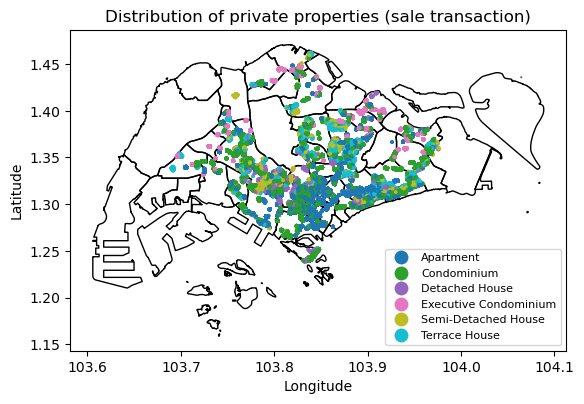

In [68]:
ax = planningArea_shp.plot(ec='k',fc='None')
residential_transaction_df.plot(ax=ax,column='Property Type',markersize=3,
                                legend=True,
                                legend_kwds={"fontsize":8,"loc":"lower right"})
ax.set_title("Distribution of private properties (sale transaction)")
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")

### Count number of bus stops and MRTs intersecting with property

In [121]:
busStopsCount = busStops_400m_buffer.sjoin(residential_transaction_df,how="right")
busStopsCount = busStopsCount.groupby(['Project Name','ADDRESS'])['stop_code'].count().reset_index().rename(columns={"stop_code":"Number of bus stops"})

trainExitsCount = trainExits_400m_buffer.sjoin(residential_transaction_df,how="right")
trainExitsCount = trainExitsCount.groupby(['Project Name','ADDRESS'])['stn_name'].count().reset_index().rename(columns={"stn_name":"Number of MRT exits"})

# merge bus stop and MRT exit counts
residential_transaction_df = residential_transaction_df.merge(busStopsCount)
residential_transaction_df = residential_transaction_df.merge(trainExitsCount)

### Add floor level variable

In [122]:
# extract floor number based on Address
def extract_floor_number(row):
    if row['Property Type'] in ['Apartment', 'Condominium', 'Executive Condominium']:
        address = row['Address']
        result = re.search('#(.*)-',address)
        if result is None:
            return np.nan
        else:
            floor_str = result.group(1)
            # if numeric val, cast to numeric
            try:
                floor_num = int(floor_str)
            except:
                # if floor number has a letter, it will throw an exception, then keep the original str
                try:
                    # if address is in the basement, convert it the negative number to represent basement
                    floor_num = int(floor_str.replace('B','')) * -1
                except:
                    floor_num = floor_str
            return floor_num
    else:
        return 0 # zero floor to represent landed properties

residential_transaction_df['Floor Level'] = residential_transaction_df.apply(lambda x: extract_floor_number(x),axis=1)

### Add variables representing accessibility to major workplace clusters

In [93]:

# calculate travel time to nearest workplace cluster
# def get_travel_time_to_workplace(G_car,transaction_df,transaction_column_name,destination_df, destination_column_name):
#     """ 
#     Args:
#         G_car (networkx.Graph): graph representing the car network
#         transaction_df transaction_column_name,(pd.DataFrame): DataFrame containing residential transaction
#         transaction_column_name (str): column name in transaction_df that contains the nodesID
#         destination_df (pd.DataFrame): dataframe containing workplace pln_area, coordinates and node_ID
#         destination_column_name (str): column name in destination_df that contains the nodesID
#     Returns a DataFrame with the shortest travel time from property location to each workplace cluster in each planning area
#     """
#     df_list = []
#     for row_ix, row in destination_df.iterrows():
#         workplace_node = row[destination_column_name]
#         pln_area = row['PLN_AREA_N']
#         shortest_time = nx.shortest_path_length(G_car, source=None, target=workplace_node, weight='travel_time') # keys are all nodes in G_car, values are travel time to target
#         # convert dictionary to df
#         shortest_time = pd.DataFrame({'nodesID':list(shortest_time),f'{pln_area}_travel_time':list(shortest_time.values())})
#         # set index for easy subsetting
#         shortest_time = shortest_time.set_index('nodesID')
#         # subset transaction_df nodesID
#         # ensure that transaction_df nodes to be subsetted are in the index of shortest_time
#         intersect_nodes = set(shortest_time.index)&set(transaction_df[transaction_column_name])
#         shortest_time = shortest_time.loc[list(intersect_nodes),:]

#         df_list.append(shortest_time)
#     # merge all dataframes, combining on nodesID_property
#     travel_time_df = pd.concat(df_list, axis=1, join='outer').reset_index()
#     return travel_time_df

def get_travel_time_to_destination(G_car,transaction_df,transaction_column_name,destination_df, destination_column_name):
    """ 
    Args:
        G_car (networkx.Graph): graph representing the car network
        transaction_df transaction_column_name,(pd.DataFrame): DataFrame containing residential transaction
        transaction_column_name (str): column name in transaction_df that contains the nodesID
        destination_df (pd.DataFrame): dataframe containing workplace pln_area, coordinates and node_ID
        destination_column_name (str): column name in destination_df that contains the nodesID
    Returns a DataFrame with the shortest travel time from property location to each workplace cluster in each planning area
    """
    df_list = []
    for row_ix, row in destination_df.iterrows():
        workplace_node = row[destination_column_name]
        pln_area = row['PLN_AREA_N']
        shortest_time = nx.shortest_path_length(G_car, source=None, target=workplace_node, weight='travel_time') # keys are all nodes in G_car, values are travel time to target
        shortest_time_property_workplace = []
        # for _, row_trans in transaction_df[[transaction_column_name,'Address','Date']].iterrows():
        for ix in transaction_df.index:
            nodes_key = transaction_df.loc[ix, transaction_column_name]
            address = transaction_df.loc[ix, "Address"]
            date = transaction_df.loc[ix, "Date"]

            try:
                shortest_time_property_workplace.append({transaction_column_name:nodes_key, f'{pln_area}_travel_time':shortest_time[nodes_key], 
                                                         'Address':address, 'Date':date})
            except:
                shortest_time_property_workplace.append({transaction_column_name:nodes_key, f'{pln_area}_travel_time':np.nan,
                                                         'Address':address, 'Date':date})

        df_travel_time = pd.DataFrame(shortest_time_property_workplace)
        df_list.append(df_travel_time)

    # merge all dataframes, combining on nodesID_property
    travel_time_df = pd.concat([d.set_index([transaction_column_name,"Address","Date"]) for d in df_list], axis=1, join='outer').reset_index()
    # create a column that shows the planning area work cluster with the minimum travel time
    travel_time_df['min_travel_time_work_region'] = travel_time_df.iloc[:,3:].idxmin(axis=1).str.replace("_travel_time","")
    # create a column that shows the minimum travel time to the closest work cluster
    travel_time_df['min_travel_time_work'] = travel_time_df.iloc[:,3:-1].min(axis=1)

    return travel_time_df


travel_time_workplace = get_travel_time_to_destination(G_car,residential_transaction_df,'nodesID_property',
                                                     workplace_cluster[workplace_cluster['PLN_AREA_N'].isin(['DOWNTOWN CORE','TAMPINES','JURONG EAST','ANG MO KIO', 'WOODLANDS'])],
                                                     'node_ID')
print("Length of travel time to workplace: ", len(travel_time_workplace))

travel_time_workplace.head()


Length of travel time to workplace:  267452


C:\Users\hypak\AppData\Local\Temp\ipykernel_23880\3828057981.py:66: FutureWarning: The behavior of DataFrame.idxmin with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  travel_time_df['min_travel_time_work_region'] = travel_time_df.iloc[:,3:].idxmin(axis=1).str.replace("_travel_time","")


,nodesID_property,Address,Date,DOWNTOWN CORE_travel_time,TAMPINES_travel_time,WOODLANDS_travel_time,ANG MO KIO_travel_time,JURONG EAST_travel_time,min_travel_time_work_region,min_travel_time_work
0,437138895,481 YIO CHU KANG ROAD #05-02,2014-01-02,817.593729,969.927205,582.116356,55.611099,1180.705147,ANG MO KIO,55.611099
1,7495834879,52 HUME AVENUE #01-16,2014-01-02,906.462413,1192.301903,679.252533,894.971270,495.595984,JURONG EAST,495.595984
2,4727949662,41 BRIGHT HILL DRIVE #14-01,2014-01-02,691.396043,899.017365,712.713872,231.689071,947.142241,ANG MO KIO,231.689071
3,6540315280,103 HILLVIEW RISE #10-11,2014-01-03,966.753995,1210.953524,656.295142,899.633176,525.733762,JURONG EAST,525.733762
4,311986889,628 UPPER THOMSON ROAD #05-61,2014-01-03,844.905078,1021.738837,610.659748,81.448453,1154.819436,ANG MO KIO,81.448453


### Add variables representing accessibility to top primary schools

In [92]:
def get_travel_time_to_school(G,transaction_df,transaction_column_name,destination_df, destination_column_name):
    """ 
    Args:
        G (networkx.Graph): graph representing the car network
        transaction_df transaction_column_name,(pd.DataFrame): DataFrame containing residential transaction
        transaction_column_name (str): column name in transaction_df that contains the nodesID
        destination_df (pd.DataFrame): dataframe containing school pln_area, coordinates and node_ID
        destination_column_name (str): column name in destination_df that contains the nodesID
    Returns a DataFrame with the shortest distance (in metres) from property location to each workplace cluster in each planning area
    """
    df_list = []
    for row_ix, row in destination_df.iterrows():
        sch = row['School Name']
        workplace_node = row[destination_column_name]
        shortest_time = nx.shortest_path_length(G, source=None, target=workplace_node, weight='length') # keys are all nodes in G, values are travel time to target
        shortest_time_property_workplace = []
        for ix in transaction_df.index:
            nodes_key = transaction_df.loc[ix, transaction_column_name]
            address = transaction_df.loc[ix, "Address"]
            date = transaction_df.loc[ix, "Date"]
            try:
                shortest_time_property_workplace.append({transaction_column_name: nodes_key, f'{sch}_distance':shortest_time[nodes_key],
                                                         'Address':address, 'Date':date})
            except:
                shortest_time_property_workplace.append({transaction_column_name: nodes_key, f'{sch}_distance':np.nan,
                                                         'Address':address, 'Date':date})

        df_travel_time = pd.DataFrame(shortest_time_property_workplace)
        df_list.append(df_travel_time)

    # merge all dataframes, combining on nodesID_property
    travel_time_df = pd.concat([d.set_index([transaction_column_name,"Address","Date"]) for d in df_list], axis=1, join='outer').reset_index()
    
    oneKm_thresh = 1000 # 1km threshold
    twoKm_thresh = 2000 # 2km threshold
    # school columns
    school_columns = travel_time_df.columns[3:] # first 3 columns are property attributes
    # check if there are any values less than 1 km or 2km, then add a boolean column
        
    travel_time_df['within_1km'] = travel_time_df[school_columns].apply(lambda x: x<oneKm_thresh, axis=1).any(axis=1)
    travel_time_df['within_2km'] = travel_time_df[school_columns].apply(lambda x: x<twoKm_thresh, axis=1).any(axis=1)
    # minimum distance (closest sch) to top 50 primary schools
    travel_time_df['min_distance'] = travel_time_df[school_columns].min(axis=1)
    return travel_time_df


travel_time_school_walk = get_travel_time_to_school(G_walk,residential_transaction_df,'nodesID_property',
                                                     topPrimarySch, # destination are top 50 primary schools
                                                     destination_column_name='nodesID_school_walk')
travel_time_school_car = get_travel_time_to_school(G_car,residential_transaction_df,'nodesID_property',
                                                     topPrimarySch, # destination are top 50 primary schools
                                                     destination_column_name='nodesID_school_car')
print("Length of distance (walk) to top primary schools: ", len(travel_time_school_walk))
print("Length of distance (car) to top primary schools: ", len(travel_time_school_car))

travel_time_school_walk.head()

Length of distance (walk) to top primary schools:  267452
Length of distance (car) to top primary schools:  267452


,nodesID_property,Address,Date,Methodist Girls' School (Primary)_distance,Tao Nan School_distance,Ai Tong School_distance,Holy Innocents' Primary School_distance,CHIJ St. Nicholas Girls' School_distance,Admiralty Primary School_distance,St. Joseph's Institution Junior_distance,...,River Valley Primary School_distance,Anderson Primary School_distance,Gongshang Primary School_distance,Hong Wen School_distance,Bukit Panjang Primary School_distance,St. Gabriel's Primary School_distance,Frontier Primary School_distance,within_1km,within_2km,min_distance
0,437138895,481 YIO CHU KANG ROAD #05-02,2014-01-02,8142.994642,11703.759442,4116.573602,7983.425439,2483.811966,10291.526294,8740.820285,...,11870.593698,736.056163,15456.078159,9245.100161,15765.788276,6907.477981,21751.902946,True,True,736.056163
1,7495834879,52 HUME AVENUE #01-16,2014-01-02,16787.686254,13020.661292,10588.459060,18980.925902,12590.288328,13665.132792,11166.759334,...,12043.087593,13692.958527,25408.603106,12626.286690,2318.336004,14385.374370,9138.230087,False,False,2226.148647
2,4727949662,41 BRIGHT HILL DRIVE #14-01,2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN
3,6540315280,103 HILLVIEW RISE #10-11,2014-01-03,17528.605544,13761.580582,11323.072201,19721.845192,13324.901469,12733.243039,11907.678624,...,12784.006883,14427.571668,26149.522396,13367.205981,1386.446251,15126.293660,9601.762724,False,True,1386.446251
4,311986889,628 UPPER THOMSON ROAD #05-61,2014-01-03,9036.433240,11222.478766,2883.284287,9034.944919,2142.995434,11154.236895,8259.539608,...,11389.313022,1863.025218,16666.042287,9159.377587,14355.446536,7721.120279,20341.561207,False,True,1863.025218


#### Merge travel time to work and school (walk and car)

In [123]:
rename_vars = ['within_1km','within_2km','min_distance']
travel_time_school_car_short = travel_time_school_car[['nodesID_property','Address','Date','within_1km','within_2km','min_distance']].rename(columns=lambda x: f'{x}_school_car' if x in rename_vars else x)
travel_time_school_walk_short = travel_time_school_walk[['nodesID_property','Address','Date','within_1km','within_2km','min_distance']].rename(columns=lambda x: f'{x}_school_walk' if x in rename_vars else x)
travel_time_workplace_short = travel_time_workplace[['nodesID_property','Address','Date','min_travel_time_work_region','min_travel_time_work']]
residential_transaction_df = reduce(lambda  left,right: pd.merge(left,right),[residential_transaction_df,travel_time_school_car_short,travel_time_school_walk_short,travel_time_workplace_short])
print(residential_transaction_df.columns)
residential_transaction_df.head()

Index(['Project Name', 'Transacted Price ($)', 'Area (SQFT)',
       'Unit Price ($ PSF)', 'Date', 'Address', 'Type of Sale', 'Type of Area',
       'Area (SQM)', 'Unit Price ($ PSM)', 'Nett Price($)', 'Property Type',
       'Number of Units', 'Tenure', 'Completion Date',
       'Purchaser Address Indicator', 'Postal Code', 'Postal District',
       'Postal Sector', 'REGION_N', 'PLN_AREA_N', 'SEARCHVAL', 'BLK_NO',
       'ROAD_NAME', 'BUILDING', 'ADDRESS', 'POSTAL', 'X', 'Y', 'latitude',
       'longitude', 'geometry', 'nodesID_property', 'Number of bus stops',
       'Number of MRT exits', 'Floor Level', 'within_1km_school_car',
       'within_2km_school_car', 'min_distance_school_car',
       'within_1km_school_walk', 'within_2km_school_walk',
       'min_distance_school_walk', 'min_travel_time_work_region',
       'min_travel_time_work'],
      dtype='object')


,Project Name,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Date,Address,Type of Sale,Type of Area,Area (SQM),Unit Price ($ PSM),...,Number of MRT exits,Floor Level,within_1km_school_car,within_2km_school_car,min_distance_school_car,within_1km_school_walk,within_2km_school_walk,min_distance_school_walk,min_travel_time_work_region,min_travel_time_work
0,CASTLE GREEN,950000,1151.75,825,2014-01-02,481 YIO CHU KANG ROAD #05-02,Resale,Strata,107.0,8879,...,0,5.0,False,True,1032.456641,True,True,736.056163,ANG MO KIO,55.611099
1,SUMMERHILL,1650000,1550.02,1065,2014-01-02,52 HUME AVENUE #01-16,Resale,Strata,144.0,11458,...,51,1.0,False,False,2967.670638,False,False,2226.148647,JURONG EAST,495.595984
2,THOMSON THREE,1051000,731.95,1436,2014-01-02,41 BRIGHT HILL DRIVE #14-01,New Sale,Strata,68.0,15456,...,174,14.0,False,False,2670.143610,False,False,NaN,ANG MO KIO,231.689071
3,KINGSFORD . HILLVIEW PEAK,730000,516.67,1413,2014-01-03,103 HILLVIEW RISE #10-11,New Sale,Strata,48.0,15208,...,0,10.0,False,False,2835.659976,False,True,1386.446251,JURONG EAST,525.733762
4,MEADOWS @ PEIRCE,2518000,3035.45,830,2014-01-03,628 UPPER THOMSON ROAD #05-61,Resale,Strata,282.0,8929,...,0,5.0,False,True,1734.786925,False,True,1863.025218,ANG MO KIO,81.448453


### Merge nodes' centrality metrics

In [126]:
betweeness_centrality = utils.load_pickle(r"Data\Gcar_node_betweeness_centrality.pkl")
closeness_centrality = utils.load_pickle(r"Data\Gcar_node_closeness_centrality.pkl")
print("Number of centrality nodes: ", len(list(betweeness_centrality)))
# betweeness_centrality
# closeness_centrality = nx.closeness_centrality(G_car)
# betweeness_centrality = nx.betweenness_centrality(G_car)
# utils.pickle_data(closeness_centrality,os.path.join(os.getcwd(),"Data","Gcar_node_closeness_centrality.pkl"))
# utils.pickle_data(betweeness_centrality,os.path.join(os.getcwd(),"Data","Gcar_node_betweeness_centrality.pkl"))
betweeness_centrality = pd.DataFrame({'nodesID_property': list(betweeness_centrality),'betweeness_centrality':list(betweeness_centrality.values())})
closeness_centrality = pd.DataFrame({'nodesID_property': list(closeness_centrality),'closeness_centrality':list(closeness_centrality.values())})
residential_transaction_df = reduce(lambda  left,right: pd.merge(left,right),[residential_transaction_df,betweeness_centrality,closeness_centrality])
print(residential_transaction_df.columns)
residential_transaction_df.head()

Number of centrality nodes:  24001
Index(['Project Name', 'Transacted Price ($)', 'Area (SQFT)',
       'Unit Price ($ PSF)', 'Date', 'Address', 'Type of Sale', 'Type of Area',
       'Area (SQM)', 'Unit Price ($ PSM)', 'Nett Price($)', 'Property Type',
       'Number of Units', 'Tenure', 'Completion Date',
       'Purchaser Address Indicator', 'Postal Code', 'Postal District',
       'Postal Sector', 'REGION_N', 'PLN_AREA_N', 'SEARCHVAL', 'BLK_NO',
       'ROAD_NAME', 'BUILDING', 'ADDRESS', 'POSTAL', 'X', 'Y', 'latitude',
       'longitude', 'geometry', 'nodesID_property', 'Number of bus stops',
       'Number of MRT exits', 'Floor Level', 'within_1km_school_car',
       'within_2km_school_car', 'min_distance_school_car',
       'within_1km_school_walk', 'within_2km_school_walk',
       'min_distance_school_walk', 'min_travel_time_work_region',
       'min_travel_time_work', 'betweeness_centrality',
       'closeness_centrality'],
      dtype='object')


,Project Name,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Date,Address,Type of Sale,Type of Area,Area (SQM),Unit Price ($ PSM),...,within_1km_school_car,within_2km_school_car,min_distance_school_car,within_1km_school_walk,within_2km_school_walk,min_distance_school_walk,min_travel_time_work_region,min_travel_time_work,betweeness_centrality,closeness_centrality
0,CASTLE GREEN,950000,1151.75,825,2014-01-02,481 YIO CHU KANG ROAD #05-02,Resale,Strata,107.0,8879,...,False,True,1032.456641,True,True,736.056163,ANG MO KIO,55.611099,0.004948,0.021799
1,SUMMERHILL,1650000,1550.02,1065,2014-01-02,52 HUME AVENUE #01-16,Resale,Strata,144.0,11458,...,False,False,2967.670638,False,False,2226.148647,JURONG EAST,495.595984,0.001941,0.019054
2,THOMSON THREE,1051000,731.95,1436,2014-01-02,41 BRIGHT HILL DRIVE #14-01,New Sale,Strata,68.0,15456,...,False,False,2670.143610,False,False,NaN,ANG MO KIO,231.689071,0.002333,0.018337
3,KINGSFORD . HILLVIEW PEAK,730000,516.67,1413,2014-01-03,103 HILLVIEW RISE #10-11,New Sale,Strata,48.0,15208,...,False,False,2835.659976,False,True,1386.446251,JURONG EAST,525.733762,0.000000,0.019566
4,MEADOWS @ PEIRCE,2518000,3035.45,830,2014-01-03,628 UPPER THOMSON ROAD #05-61,Resale,Strata,282.0,8929,...,False,True,1734.786925,False,True,1863.025218,ANG MO KIO,81.448453,0.000083,0.018618


In [14]:
print("Length of df: ",len(residential_transaction_df))
print(f"Number of unique project name: {len(np.unique(residential_transaction_df['Project Name']))}")
print(f"Number of unique property types: {len(np.unique(residential_transaction_df['Property Type']))}")
print(np.unique(residential_transaction_df['Property Type']))
# Apartments still include condos
print(f"Min of unit price PSM: {residential_transaction_df["Unit Price ($ PSM)"].min()}; Max of unit price PSM: {residential_transaction_df["Unit Price ($ PSM)"].max()}")
print(f"Number of unique planning region: {len(np.unique(residential_transaction_df["REGION_N"]))}")
print(f"Number of unique planning area: {len(np.unique(residential_transaction_df["PLN_AREA_N"]))}")
print("Column names: ", residential_transaction_df.columns)
print("Number of columns:", len(residential_transaction_df.columns))

Length of df:  267452
Number of unique project name: 3179
Number of unique property types: 6
['Apartment' 'Condominium' 'Detached House' 'Executive Condominium'
 'Semi-Detached House' 'Terrace House']
Min of unit price PSM: 1072; Max of unit price PSM: 70964
Number of unique planning region: 5
Number of unique planning area: 42
Column names:  Index(['Project Name', 'Transacted Price ($)', 'Area (SQFT)',
       'Unit Price ($ PSF)', 'Date', 'Address', 'Type of Sale', 'Type of Area',
       'Area (SQM)', 'Unit Price ($ PSM)', 'Nett Price($)', 'Property Type',
       'Number of Units', 'Tenure', 'Completion Date',
       'Purchaser Address Indicator', 'Postal Code', 'Postal District',
       'Postal Sector', 'REGION_N', 'PLN_AREA_N', 'SEARCHVAL', 'BLK_NO',
       'ROAD_NAME', 'BUILDING', 'ADDRESS', 'POSTAL', 'X', 'Y', 'latitude',
       'longitude', 'Floor Level', 'nodesID_property'],
      dtype='object')
Number of columns: 33


### Check if floor number has letters

In [21]:
x = residential_transaction_df[~residential_transaction_df['Floor Level'].astype(str).str.isnumeric()]
x[~x['Floor Level'].isna()][['Floor Level']]
residential_transaction_df[residential_transaction_df['Floor Level'].isna()][['Property Type','Floor Level']]
residential_transaction_df[residential_transaction_df['Floor Level']<0].head()

,Project Name,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Date,Address,Type of Sale,Type of Area,Area (SQM),Unit Price ($ PSM),...,ROAD_NAME,BUILDING,ADDRESS,POSTAL,X,Y,latitude,longitude,Floor Level,nodesID_property
39029,ST PATRICK'S RESIDENCES,2798888,2238.91,1250,2015-02-17,60 ST. PATRICK'S ROAD #B1-17,Resale,Strata,208.0,13456,...,SAINT PATRICK'S ROAD,SAINT PATRICK'S RESIDENCES,60 SAINT PATRICK'S ROAD SAINT PATRICK'S RESIDE...,423467.0,37051.627096,32277.296605,1.308178,103.914652,-1.0,2381043681
39996,ST PATRICK'S RESIDENCES,2800000,2249.68,1245,2015-08-03,58 ST. PATRICK'S ROAD #B1-13,Resale,Strata,209.0,13397,...,SAINT PATRICK'S ROAD,SAINT PATRICK'S RESIDENCES,58 SAINT PATRICK'S ROAD SAINT PATRICK'S RESIDE...,424218.0,37066.851045,32241.078481,1.307850,103.914789,-1.0,2325380853
40230,ST PATRICK'S RESIDENCES,3588000,3164.62,1134,2015-09-04,58 ST. PATRICK'S ROAD #B1-16,Resale,Strata,294.0,12204,...,SAINT PATRICK'S ROAD,SAINT PATRICK'S RESIDENCES,58 SAINT PATRICK'S ROAD SAINT PATRICK'S RESIDE...,424218.0,37066.851045,32241.078481,1.307850,103.914789,-1.0,2325380853
47077,HOLLAND PEAK,2380000,1819.12,1308,2017-07-11,25 HOLLAND HILL #B1-03,Resale,Strata,169.0,14083,...,HOLLAND HILL,HOLLAND PEAK,25 HOLLAND HILL HOLLAND PEAK SINGAPORE 278740,278740.0,24479.932656,32333.204507,1.308684,103.801689,-1.0,243415101
48263,THE DAFFODIL,720000,742.72,969,2017-09-29,568 UPPER EAST COAST ROAD #B1-02,Resale,Strata,69.0,10435,...,UPPER EAST COAST ROAD,THE DAFFODIL,568 UPPER EAST COAST ROAD THE DAFFODIL SINGAPO...,466584.0,40504.256136,33144.786160,1.316022,103.945676,-1.0,4690796879


# Suitable models for assessing impact of flood on property prices

## 1. Hedonic Pricing Model
- What it does: Decomposes property prices into the value of their attributes (e.g., location, size, amenities, flood exposure).
- How to use it: Include flood risk or flood event indicators as independent variables.
- Limitation: It captures correlation, not necessarily causation, unless flood exposure is exogenous (Still useful as a baseline)

## 2. Difference-in-Differences (DiD)
- Best for: Estimating causal effects of floods on property prices.
- Design: Compare price changes in flood-affected areas (treatment group) vs. unaffected but otherwise similar areas (control group), before and after a flood.
- Assumptions:
    - Parallel trends before the event.
    - No other major confounding event around the same time.
    - You can add leads and lags to check for anticipation effects and recovery time.

## 3. Event Study / Distributed Lag Model (DLM)
- What it does: Models the dynamic effect of a flood over time.
- How: Include time dummies for each period relative to the flood (e.g., t−3, t−2, t−1, t, t+1, ..., t+n).
- Use with DiD: To assess how prices behave before and after the event in treated vs control areas.
- Great for checking if recency bias exists (e.g., prices recover a few years post-flood).

## 4. Repeat Sales Model
- What it does: Tracks the same property over time to control for unobserved characteristics.
- How: Uses price differences from previous sales of the same property.
- Limitations: Only works for properties that are sold multiple times.

## 5. Fixed Effects Panel Regression
- Design: If you have panel data (i.e., multiple observations of the same property over time), this model controls for time-invariant unobservable traits of each property.
- Additions:
    - Time fixed effects (to control for market trends)
    - Property fixed effects (to control for inherent property differences)

# Control versus fixed effects
- Control variables: Explain variation in the outcome variable. Used as dependent variable (explanatory variables) e.g. size of house, distance to MRT, housing type
- Fixed effects: Control for unobservable, constant differences across units (property type, locations, time periods etc) (used as dummy variables) e.g. specific neighbourhood effect that doesn't change over time

# Variables (data type)
### Dependent variable
- `Transacted Price`: Numeric (dependent variable i.e. y-variable)
- log prices
### Treatment
- `Flood_event`: Indicator if property was affected by a flood (within X months). Binary (0/1). Treatment indicator
- `Post_flood`: Indicator for post-flood period (Binary) Time indicator to indicate whether an observation occurred after the flood event.
- `flood_event × post_flood`: Interaction: treatment effect of flood (Binary). Key independent variable for DiD
### Control variables
- `floor_area`: numeric; control variable
- `property_type`:  HDB / Condo / Landed; Categorical (nominal); control variable
- `Floor Level`: Numeric; control variable
- `year_built`: Year of construction; Numeric; control variable
- `distance_to_public transit`: Distance in meters; Numeric; Control variable
    - `walking_distance_to_nearest_bus_stop`: walking distance to the various MRT lines (e.g. ewl, tel, ccl etc)
    - `walking_distance_to_MRT`: walking distance to the various MRT lines (e.g. ewl, tel, ccl etc)
    - `Number of bus stops going to MRT`: convenience of taking buses to the nearest MRT lines. Use GTFS data, and for each bus stop ID code, see how many buses go to MRT and how long it takes to reach the nearest MRT.
- `Centrality of location`: 
    - Driving time to various work clusters in each planning area
- `Number of amenities`
### Fixed effects
- `district`: Neighborhood district code e.g. planning area, planning region; Categorical; Fixed effect (e.g. location)
- `property_id`: Unique property ID e.g. project name or building name; Identifier; fixed effects
- `transaction_date`: sale date, Used to construct `post_flood` and time fixed effects

### Merge flood and transaction prices

In [22]:
flood_residential_transaction = residential_transaction_df.merge(flood_df,on=['PLN_AREA_N','REGION_N','Date'], how="left",suffixes=['','_flood'])
print(f"Column names: {flood_residential_transaction.columns}")
# check whether any flood occured in the same planning area
# identify the most recent local flood date before the sale
# calculate months_since_flood. If no flood occurred at the location, the property is in the control group
print("Length of df: ", len(flood_residential_transaction))

# split df by planning area
flood_transaction_plnArea = {pln:df.sort_values(by='Date', ascending=True) for pln, df in flood_residential_transaction.groupby('PLN_AREA_N')}
flood_transaction_plnArea['YISHUN'].head()

Column names: Index(['Project Name', 'Transacted Price ($)', 'Area (SQFT)',
       'Unit Price ($ PSF)', 'Date', 'Address', 'Type of Sale', 'Type of Area',
       'Area (SQM)', 'Unit Price ($ PSM)', 'Nett Price($)', 'Property Type',
       'Number of Units', 'Tenure', 'Completion Date',
       'Purchaser Address Indicator', 'Postal Code', 'Postal District',
       'Postal Sector', 'REGION_N', 'PLN_AREA_N', 'SEARCHVAL', 'BLK_NO',
       'ROAD_NAME', 'BUILDING', 'ADDRESS', 'POSTAL', 'X', 'Y', 'latitude',
       'longitude', 'Floor Level', 'nodesID_property', 'flooded_location',
       'responses_found', 'matched_location', 'latitude_flood',
       'longitude_flood', 'closest_weather_stn', 'mean_pr',
       'daily rainfall total (mm)', 'highest 30 min rainfall (mm)',
       'highest 60 min rainfall (mm)', 'highest 120 min rainfall (mm)',
       'drainage_catchment', 'time', 'geometry', 'index_right',
       'nodesID_flood'],
      dtype='object')
Length of df:  267514


,Project Name,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Date,Address,Type of Sale,Type of Area,Area (SQM),Unit Price ($ PSM),...,mean_pr,daily rainfall total (mm),highest 30 min rainfall (mm),highest 60 min rainfall (mm),highest 120 min rainfall (mm),drainage_catchment,time,geometry,index_right,nodesID_flood
232464,1 CANBERRA,679100,947.23,717,2014-01-02,5 CANBERRA DRIVE #02-12,New Sale,Strata,88.0,7717,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
232465,NINE RESIDENCES,1161000,1173.28,990,2014-01-07,14 YISHUN AVENUE 9 #09-19,New Sale,Strata,109.0,10651,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
232466,1 CANBERRA,693500,947.23,732,2014-01-07,25 CANBERRA DRIVE #02-50,New Sale,Strata,88.0,7881,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
232467,1 CANBERRA,702200,958.00,733,2014-01-07,23 CANBERRA DRIVE #02-46,New Sale,Strata,89.0,7890,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
232469,THE ESTUARY,1268888,1442.38,880,2014-01-08,93 YISHUN AVENUE 1 #01-21,Resale,Strata,134.0,9469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN


In [23]:
flood_residential_transaction[~flood_residential_transaction['flooded_location'].isna()]['PLN_AREA_N'].unique()
flood_residential_transaction[~flood_residential_transaction['time'].isna()]
flood_residential_transaction['PLN_AREA_N'].unique()

array(['ANG MO KIO', 'BUKIT BATOK', 'BISHAN', 'CLEMENTI', 'BUKIT PANJANG',
       'BEDOK', 'BUKIT TIMAH', 'BUKIT MERAH', 'CHOA CHU KANG',
       'DOWNTOWN CORE', 'HOUGANG', 'JURONG WEST', 'CHANGI  ', 'KALLANG',
       'GEYLANG', 'MANDAI', 'JURONG EAST', 'MARINE PARADE', 'NOVENA',
       'NEWTON', 'MUSEUM', 'ORCHARD', 'MARINA SOUTH', 'PUNGGOL',
       'RIVER VALLEY', 'OUTRAM', 'PAYA LEBAR', 'PASIR RIS', 'QUEENSTOWN',
       'ROCHOR', 'SEMBAWANG', 'SINGAPORE RIVER', 'SERANGOON', 'SENGKANG',
       'TANGLIN', 'SOUTHERN ISLANDS', 'SUNGEI KADUT', 'YISHUN',
       'TAMPINES', 'TENGAH', 'WOODLANDS', 'TOA PAYOH'], dtype=object)

### Compute `weeks_since_flood` to understand if prices decrease or increase in a fixed pattern over time

In [27]:
def compute_weeks_since_flood(transaction_df, last_flood_date):
    """    
    Args:
        transaction_df (pd.DataFrame): DataFrame containing residential transactions with flood information
        last_flood_date (str): last flood date in the format %Y_%m-%d before 2014 used to fill the first few NA entries of last flood date
    Returns:
        pd.DataFrame: DataFrame with an additional column 'weeks_since_flood' indicating the number of weeks since the most recent flood before the sale date
    """
    df = transaction_df.copy()
    df['Date_flood'] = pd.to_datetime(df['time'], format='%Y-%m-%d', errors='coerce')
    # fill flood dates down to reflect the last flooded date before the sale date
    df['Date_flood'] = df['Date_flood'].ffill()
    # for the first few NA entries, assume no flood before sale date # TODO: check when was the last flooded date before 2014
    df['Date_flood'] = df['Date_flood'].fillna(pd.to_datetime(last_flood_date, format='%Y-%m-%d', errors='coerce'))
    # compute weeks since flood
    df['weeks_since_flood'] = (df['Date'] - df['Date_flood'])/np.timedelta64(1,'W')
    return df
compute_weeks_since_flood(flood_transaction_plnArea['YISHUN'],'2013-01-01')

flood_residential_transaction.groupby('PLN_AREA_N').apply(lambda x: compute_weeks_since_flood(x,'2013-01-01')).reset_index(drop=True)

C:\Users\hypak\AppData\Local\Temp\ipykernel_9428\732024637.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  flood_residential_transaction.groupby('PLN_AREA_N').apply(lambda x: compute_weeks_since_flood(x,'2013-01-01')).reset_index(drop=True)


,Project Name,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Date,Address,Type of Sale,Type of Area,Area (SQM),Unit Price ($ PSM),...,highest 30 min rainfall (mm),highest 60 min rainfall (mm),highest 120 min rainfall (mm),drainage_catchment,time,geometry,index_right,nodesID_flood,Date_flood,weeks_since_flood
0,CASTLE GREEN,950000,1151.75,825,2014-01-02,481 YIO CHU KANG ROAD #05-02,Resale,Strata,107.0,8879,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,2013-01-01,52.285714
1,MEADOWS @ PEIRCE,2518000,3035.45,830,2014-01-03,628 UPPER THOMSON ROAD #05-61,Resale,Strata,282.0,8929,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,2013-01-01,52.428571
2,THOMSON HILLS ESTATE,3300000,2896.59,1139,2014-01-03,27 THOMSON HILL,Resale,Land,269.1,12263,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,2013-01-01,52.428571
3,ALANA,3478100,3595.18,967,2014-01-06,184 SUNRISE TERRACE,New Sale,Strata,334.0,10413,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,2013-01-01,52.857143
4,FLORAVILLE,1020000,721.19,1414,2014-01-06,2 CACTUS ROAD #01-06,New Sale,Strata,67.0,15224,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,2013-01-01,52.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267509,THE CRITERION,1150000,914.94,1257,2025-06-06,5 YISHUN STREET 51 #02-11,Resale,Strata,85.0,13529,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,2017-11-18,393.857143
267510,HUIT,4700000,3164.62,1485,2025-06-10,10A MENG SUAN ROAD,Resale,Land,294.0,15986,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,2017-11-18,394.428571
267511,NORTH GAIA,1403000,979.52,1432,2025-06-12,31 YISHUN CLOSE #14-16,New Sale,Strata,91.0,15418,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,2017-11-18,394.714286
267512,NORTH GAIA,1412000,1001.05,1411,2025-06-12,33 YISHUN CLOSE #05-18,New Sale,Strata,93.0,15183,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,2017-11-18,394.714286


# Data analysis of property prices

### Reverse geocoding

In [ ]:
def generate_OneMap_headers():
    """ generates new one map token """
    onemapKey = get_OneMap_token()
    headers = {"Authorization": onemapKey}
    return headers

def get_coordinates_from_location(location,headers):
    """returns number of results found, search value, and coordinates given a supplied location 
    Args:
        location (str): a location in singapore
    Returns:
        tuple: strings corresponding to number of results found, search value, lat, and lon
    """
    
    url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={location}&returnGeom=Y&getAddrDetails=Y&pageNum=1"
        
    response = requests.request("GET", url, headers=headers)
    response = response.json()
    response_first_result = response['results'][0] # get first item in the list
    return response_first_result

headers = generate_OneMap_headers()
searchVal = get_coordinates_from_location(787056,headers=headers)
pd.Series(searchVal,index=list(searchVal))

In [4]:
residential_transaction_dir = r"Data\Residential Transaction"
residential_transaction_fps = [os.path.join(residential_transaction_dir,d,fp) for d in os.listdir(residential_transaction_dir) for fp in os.listdir(os.path.join(residential_transaction_dir,d))]

# residential_transaction_dfs = [pd.read_csv(fp) for fp in residential_transaction_fps]
# residential_transaction_dfs[0].head()

In [7]:
residential_transaction_dfs = []
for fp in residential_transaction_fps:
    try:
        df = pd.read_csv(fp)
    except Exception as e:
        df = pd.read_csv(fp, encoding='latin-1')
    residential_transaction_dfs.append(df)
residential_transaction_dfs[0]

residential_transaction_df = pd.concat(residential_transaction_dfs)
print(f"length of df: {len(residential_transaction_df)}")
residential_transaction_df.head()
# capitalise planning region and area
residential_transaction_df[["Planning Region", "Planning Area"]] = residential_transaction_df[["Planning Region", "Planning Area"]].apply(lambda x: x.str.upper())
# pad 0s to the left of the string because postal code is interpreted as an int64
residential_transaction_df['Postal Code'] = residential_transaction_df['Postal Code'].astype(str).str.zfill(6)
residential_transaction_df.head()

length of df: 267946


,Project Name,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Sale Date,Address,Type of Sale,Type of Area,Area (SQM),Unit Price ($ PSM),...,Property Type,Number of Units,Tenure,Completion Date,Purchaser Address Indicator,Postal Code,Postal District,Postal Sector,Planning Region,Planning Area
0,CASTLE GREEN,"950,000","1,151.75",825,02 Jan 2014,481 YIO CHU KANG ROAD #05-02,Resale,Strata,107,"8,879",...,Condominium,1,99 yrs from 01/12/1993,1997,HDB,787056,26,78,NORTH EAST REGION,ANG MO KIO
1,SUMMERHILL,"1,650,000","1,550.02","1,065",02 Jan 2014,52 HUME AVENUE #01-16,Resale,Strata,144,"11,458",...,Condominium,1,Freehold,2002,Private,596230,21,59,WEST REGION,BUKIT BATOK
2,THOMSON THREE,"1,051,000",731.95,"1,436",02 Jan 2014,41 BRIGHT HILL DRIVE #14-01,New Sale,Strata,68,"15,456",...,Apartment,1,99 yrs from 07/11/2012,Uncompleted,Private,573893,20,57,CENTRAL REGION,BISHAN
3,KINGSFORD . HILLVIEW PEAK,"730,000",516.67,"1,413",03 Jan 2014,103 HILLVIEW RISE #10-11,New Sale,Strata,48,"15,208",...,Condominium,1,99 yrs from 04/06/2012,Uncompleted,Private,667982,23,66,WEST REGION,BUKIT BATOK
4,MEADOWS @ PEIRCE,"2,518,000","3,035.45",830,03 Jan 2014,628 UPPER THOMSON ROAD #05-61,Resale,Strata,282,"8,929",...,Condominium,1,Freehold,2012,Private,787131,26,78,NORTH EAST REGION,ANG MO KIO


### Reverse geocoding based on postal code

In [ ]:
# headers = generate_OneMap_headers()
# geog_columns = get_coordinates_from_location(residential_transaction_df['Postal Code'].values[0],headers=headers)
# geog_columns = list(geog_columns)
# # add geographical coordinates based on postal code
# def postal_to_coord(row,column_names,headers):
#     try:
#         searchVal = get_coordinates_from_location(row['Postal Code'],headers=headers) 
#     except:
#         searchVal = {c:np.nan for c in column_names}
#     return pd.Series(searchVal,index=list(searchVal))

# residential_transaction_df.loc[:,geog_columns] = residential_transaction_df.apply(lambda x: postal_to_coord(x,geog_columns,headers),axis=1)
# residential_transaction_df.head()

,Project Name,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Sale Date,Address,Type of Sale,Type of Area,Area (SQM),Unit Price ($ PSM),...,SEARCHVAL,BLK_NO,ROAD_NAME,BUILDING,ADDRESS,POSTAL,X,Y,LATITUDE,LONGITUDE
0,CASTLE GREEN,"950,000","1,151.75",825,02 Jan 2014,481 YIO CHU KANG ROAD #05-02,Resale,Strata,107,"8,879",...,CASTLE GREEN,481,YIO CHU KANG ROAD,CASTLE GREEN,481 YIO CHU KANG ROAD CASTLE GREEN SINGAPORE 7...,787056,28883.6308995523,40954.9001035616,1.38665607016721,103.841258679782
1,SUMMERHILL,"1,650,000","1,550.02","1,065",02 Jan 2014,52 HUME AVENUE #01-16,Resale,Strata,144,"11,458",...,SUMMERHILL,52,HUME AVENUE,SUMMERHILL,52 HUME AVENUE SUMMERHILL SINGAPORE 596230,596230,20479.2191397604,37907.3028749451,1.35909375147895,103.765739386408
2,THOMSON THREE,"1,051,000",731.95,"1,436",02 Jan 2014,41 BRIGHT HILL DRIVE #14-01,New Sale,Strata,68,"15,456",...,THOMSON THREE,41,BRIGHT HILL DRIVE,THOMSON THREE,41 BRIGHT HILL DRIVE THOMSON THREE SINGAPORE 5...,573893,27661.1848259298,37765.0089065079,1.35780784536875,103.830274101252
3,KINGSFORD . HILLVIEW PEAK,"730,000",516.67,"1,413",03 Jan 2014,103 HILLVIEW RISE #10-11,New Sale,Strata,48,"15,208",...,KINGSFORD . HILLVIEW PEAK,103,HILLVIEW RISE,KINGSFORD . HILLVIEW PEAK,103 HILLVIEW RISE KINGSFORD . HILLVIEW PEAK SI...,667982,20304.4639392383,38537.2146058902,1.3647903996751,103.764168933657
4,MEADOWS @ PEIRCE,"2,518,000","3,035.45",830,03 Jan 2014,628 UPPER THOMSON ROAD #05-61,Resale,Strata,282,"8,929",...,MEADOWS @ PEIRCE,628,UPPER THOMSON ROAD,MEADOWS @ PEIRCE,628 UPPER THOMSON ROAD MEADOWS @ PEIRCE SINGAP...,787131,27381.7980788425,40248.1197103634,1.38026420822228,103.827763575389


In [ ]:
# convert coordinates to numeric
# residential_transaction_df[['X','Y','LATITUDE','LONGITUDE']] = residential_transaction_df[['X','Y','LATITUDE','LONGITUDE']].apply(lambda x: pd.to_numeric(x,errors='coerce') ,axis=0)
# save_dir = os.path.join(os.getcwd(),"Exported_Data")
# if not os.path.exists(save_dir):
#     os.mkdir(save_dir)
# residential_transaction_df.to_csv(os.path.join(save_dir,"Residential_transaction_2014_2024.csv"),index=False)


,Project Name,Transacted Price ($),Area (SQFT),Unit Price ($ PSF),Sale Date,Address,Type of Sale,Type of Area,Area (SQM),Unit Price ($ PSM),...,SEARCHVAL,BLK_NO,ROAD_NAME,BUILDING,ADDRESS,POSTAL,X,Y,LATITUDE,LONGITUDE
0,CASTLE GREEN,"950,000","1,151.75",825,02 Jan 2014,481 YIO CHU KANG ROAD #05-02,Resale,Strata,107,"8,879",...,CASTLE GREEN,481,YIO CHU KANG ROAD,CASTLE GREEN,481 YIO CHU KANG ROAD CASTLE GREEN SINGAPORE 7...,787056.0,28883.630900,40954.900104,1.386656,103.841259
1,SUMMERHILL,"1,650,000","1,550.02","1,065",02 Jan 2014,52 HUME AVENUE #01-16,Resale,Strata,144,"11,458",...,SUMMERHILL,52,HUME AVENUE,SUMMERHILL,52 HUME AVENUE SUMMERHILL SINGAPORE 596230,596230.0,20479.219140,37907.302875,1.359094,103.765739
2,THOMSON THREE,"1,051,000",731.95,"1,436",02 Jan 2014,41 BRIGHT HILL DRIVE #14-01,New Sale,Strata,68,"15,456",...,THOMSON THREE,41,BRIGHT HILL DRIVE,THOMSON THREE,41 BRIGHT HILL DRIVE THOMSON THREE SINGAPORE 5...,573893.0,27661.184826,37765.008907,1.357808,103.830274
3,KINGSFORD . HILLVIEW PEAK,"730,000",516.67,"1,413",03 Jan 2014,103 HILLVIEW RISE #10-11,New Sale,Strata,48,"15,208",...,KINGSFORD . HILLVIEW PEAK,103,HILLVIEW RISE,KINGSFORD . HILLVIEW PEAK,103 HILLVIEW RISE KINGSFORD . HILLVIEW PEAK SI...,667982.0,20304.463939,38537.214606,1.364790,103.764169
4,MEADOWS @ PEIRCE,"2,518,000","3,035.45",830,03 Jan 2014,628 UPPER THOMSON ROAD #05-61,Resale,Strata,282,"8,929",...,MEADOWS @ PEIRCE,628,UPPER THOMSON ROAD,MEADOWS @ PEIRCE,628 UPPER THOMSON ROAD MEADOWS @ PEIRCE SINGAP...,787131.0,27381.798079,40248.119710,1.380264,103.827764
